In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torchvision
import torch
from pathlib import Path
from PIL import Image
from pprint import pprint

from torch import nn, optim
from torchvision.models import mobilenet_v3_large
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

# custom imports
from fairface_classification import data

# launch tensorboard writer
writer = SummaryWriter('../runs/fairface')

torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def set_random_seed(seed, deterministic=False):
    """Set random seed.

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set torch.backends.cudnn.deterministic
            to True and torch.backends.cudnn.benchmark to False.
            Default: False.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seed(42)

### The following is the model architecture I am going to train on FairFace Dataset

Almost the whole model and its architecture - Mobile Net V3 Large pretrained on ImageNet dataset. The last layer is modified and adapted to current FairFace dataset. There are just 3 classes that should predicted at the same time, so the last layer of the model will have three "heads".

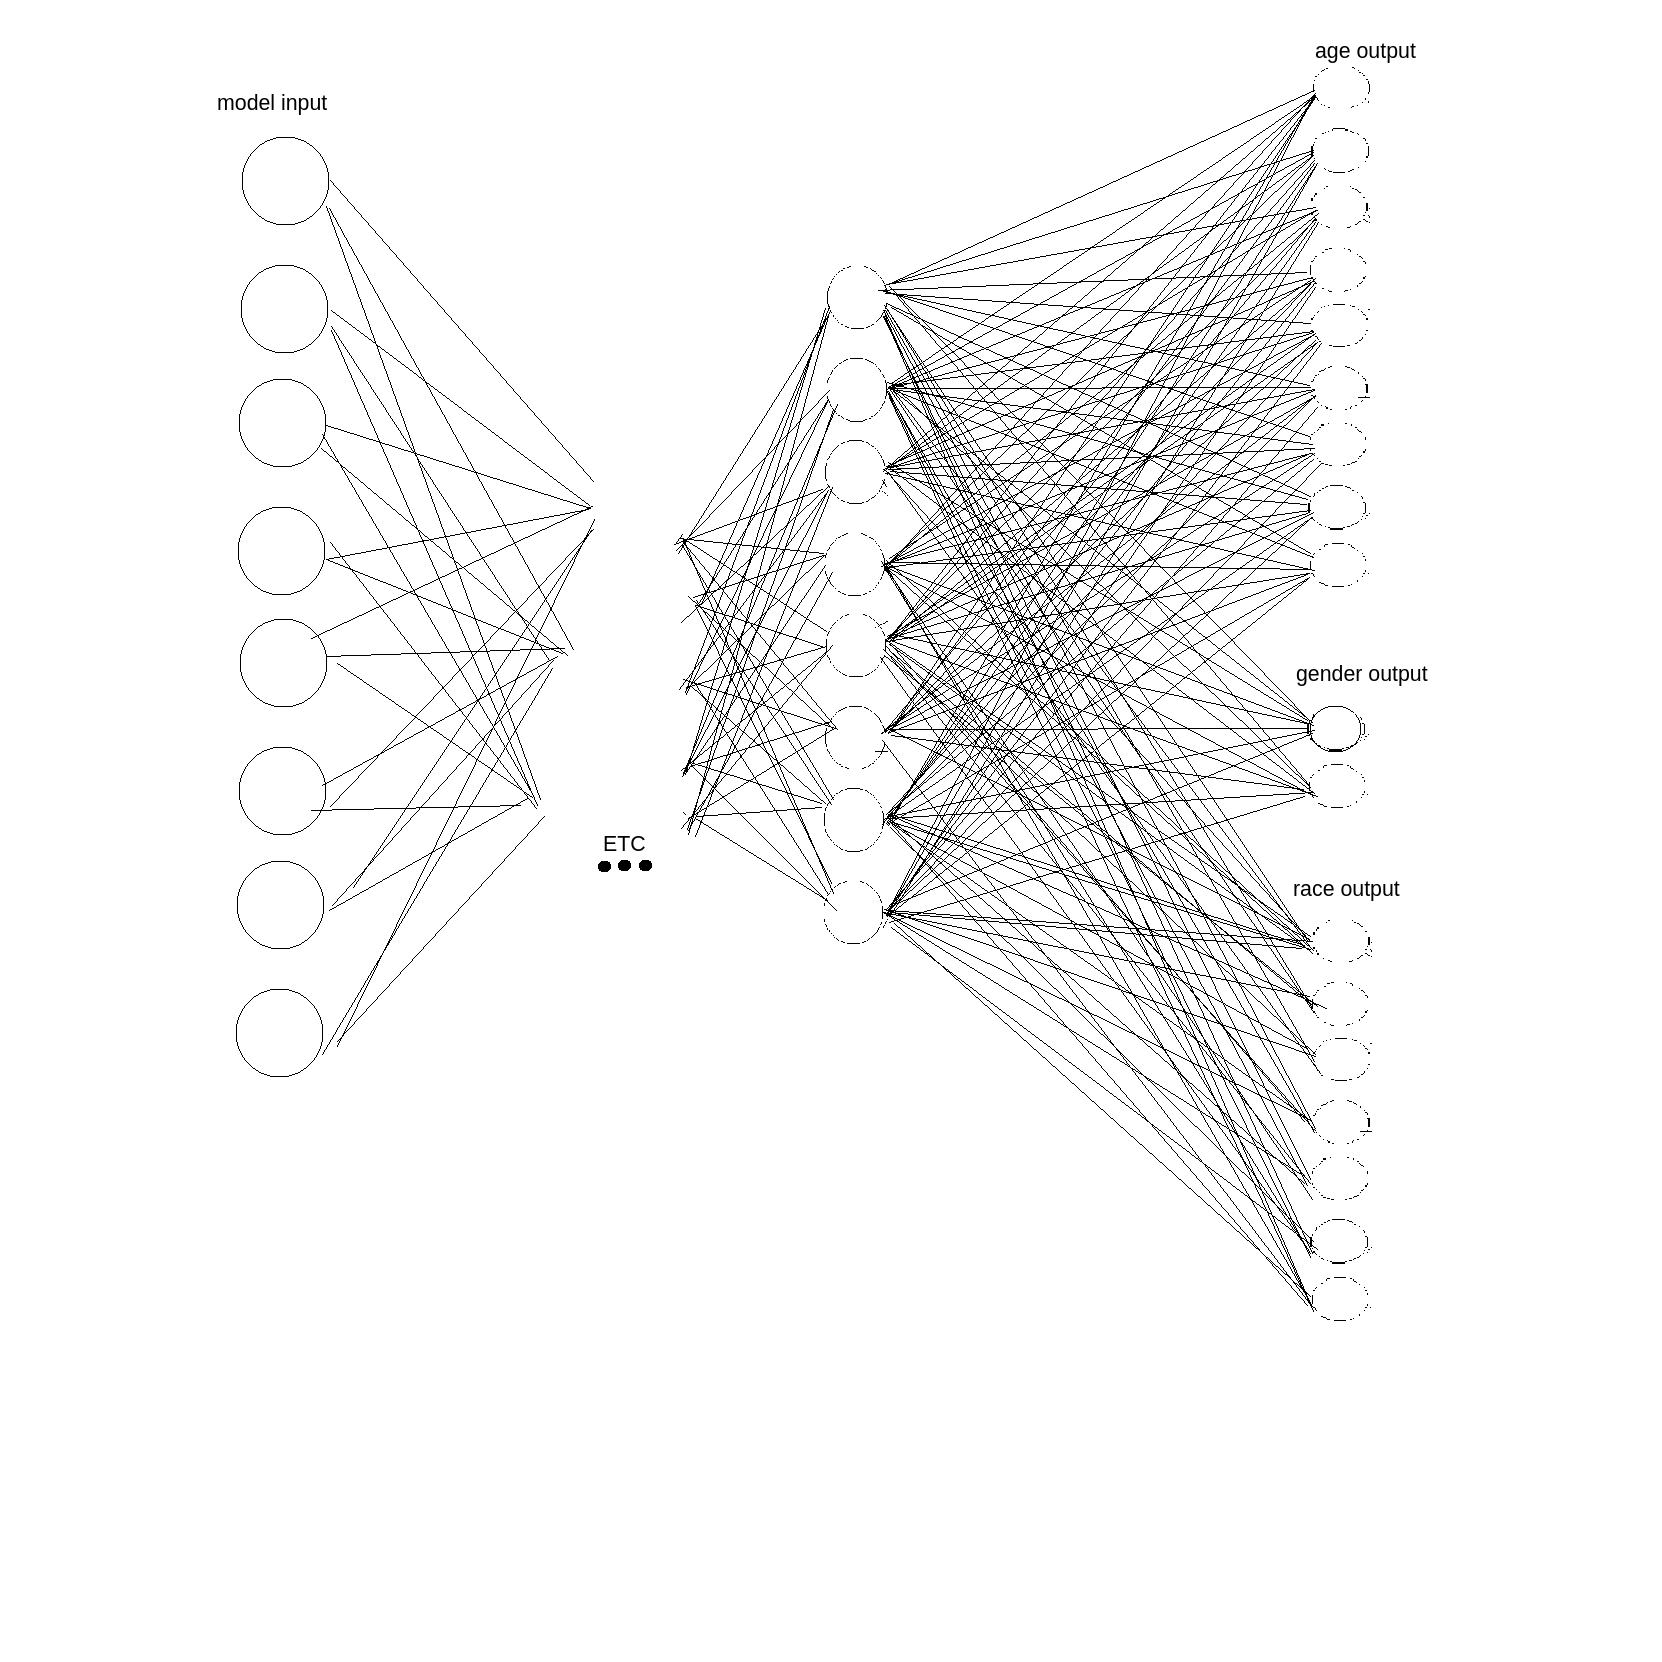

In [3]:
Image.open('../model_architecture.png')

In [4]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V1')
print(f'Mobilenet pretrained on ImageNet1k_V1 = {mobilenet}')
train_label.head()

Mobilenet pretrained on ImageNet1k_V1 = MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 6

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [5]:
root_dir = Path('/home/himars/Programming/Deep_Learning/fairface_classification/')
images_dir = 'data/'

print(root_dir, images_dir, sep='\n')

/home/himars/Programming/Deep_Learning/fairface_classification
data/


### Initialize Dataset and Dataloader

In [6]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}
pprint(encoders)

{'age': {'0-2': 0,
         '10-19': 2,
         '20-29': 3,
         '3-9': 1,
         '30-39': 4,
         '40-49': 5,
         '50-59': 6,
         '60-69': 7,
         'more than 70': 8},
 'gender': {'Female': 1, 'Male': 0},
 'race': {'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0}}


In [7]:
#   transforms.RandomHorizontalFlip(0.5),
#   transforms.RandomAffine([-15, 15]),
#   transforms.RandomPerspective(0.5),
#   transforms.GaussianBlur(),
#   transforms.RandomSolarize(threshold=0.8, p=0.1),

In [8]:
batch_size = 64

In [9]:
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.RandomVerticalFlip(p=0.5),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                           std=[0.229, 0.224, 0.225])
                                                                      ]))
fairface_train.train()
train_loader = DataLoader(fairface_train, batch_size=batch_size, shuffle=True, num_workers=5)

fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
fairface_test.train()
test_loader = DataLoader(fairface_test, batch_size=batch_size, shuffle=True, num_workers=5)

fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
fairface_val.train()
val_loader = DataLoader(fairface_val, batch_size=batch_size, shuffle=True, num_workers=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


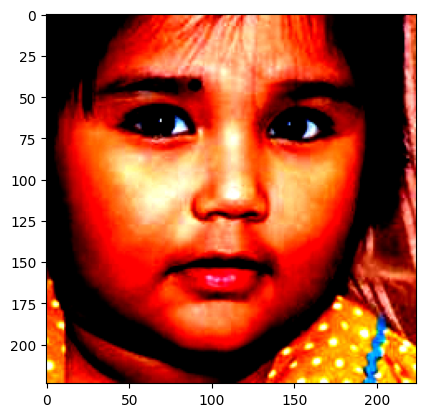

In [10]:
plt.imshow(torch.squeeze(fairface_train[35]['image']).permute(1, 2, 0))
plt.show()

### Sample data

In [11]:
img_grid = torchvision.utils.make_grid(fairface_train[13]['image'])
writer.add_image('fairface_image1', img_grid)

img_grid = torchvision.utils.make_grid(fairface_train[26]['image'])
writer.add_image('fairface_image2', img_grid)

for i in range(5):
    img_grid = torchvision.utils.make_grid(fairface_train[43 + i]['image'])
    writer.add_image(f'fairface_image{i + 3}', img_grid)

### First try of training a neural network

In [12]:
class ANN_cycle(nn.Module):
    def __init__(self, in_features, out_features, dropout_val=0.3) -> None:
        super(ANN_cycle, self).__init__()
        self.block = nn.Sequential(nn.Linear(in_features, out_features),
                                   nn.ReLU(),
                                   nn.Dropout(dropout_val))
        
    def forward(self, x):
        return self.block(x)

class ANN_Blocks(nn.Module):
    def __init__(self) -> None:
        super(ANN_Blocks, self).__init__()
        self.block = nn.Sequential(ANN_cycle(960, 512, 0.3),
                                 ANN_cycle(512, 256, 0.3),
                                 ANN_cycle(256, 128, 0.3),
                                 ANN_cycle(128, 64, 0.3),
                                 ANN_cycle(64, 32, 0.3),
                                 ANN_cycle(32, 16, 0.3))
        
    def forward(self, x):
        return self.block(x)


class FairFaceMobileNet(nn.Module):
    def __init__(self, MobileNet) -> None:
        super(FairFaceMobileNet, self).__init__()
        self.mobilenet = MobileNet
        for param in self.mobilenet.parameters():
            param.requires_grad = True

        # self.fc1 = torch.nn.Linear(960, 9) # for age class
        self.fc1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                                 nn.Flatten(), 
                                 ANN_Blocks(),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(16, 9))
        self.fc2 = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                                 nn.Flatten(), 
                                 ANN_Blocks(),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(16, 2))
        self.fc3 = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                                 nn.Flatten(), 
                                 ANN_Blocks(),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(16, 7))

    def forward(self, x):
        
        out = self.mobilenet.features(x)

        age = self.fc1(out)
        gender = self.fc2(out)

        race = self.fc3(out)

        return {'age_pred' : age, 'gender_pred' : gender, 'race_pred' : race}

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)
model = FairFaceMobileNet(mobilenet).to(device)

# For race and age classes
bce = nn.BCELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm

def get_dummy(enc_dict, label, device):
    label_classes = len(enc_dict.values())
    label_array = torch.zeros((label.shape[0], label_classes))

    for (i, label_class) in enumerate(label):
        label_array[i][label_class] = 1

    label_array = label_array.to(device)
    return label_array

def train_model(model, criterion, optimizer, scheduler_lr, device, loaders, tensor_writer, n_epochs=25):

    """Fine-tune the model and returns it"""

    use_lr_scheduler = False

    train_loader, test_loader = loaders

    data.check_train_mode_off(train_loader, 'train')
    data.check_train_mode_off(test_loader, 'test')

    cce_mark = type(criterion) == torch.nn.modules.loss.CrossEntropyLoss
    valid_loss_min = torch.inf
    

    for epoch in range(1, n_epochs):
        train_loss = .0
        age_train_loss, race_train_loss, gender_train_loss = .0, .0, .0

        model.train()

        if use_lr_scheduler:
            scheduler_lr.step()
        
        all_age_preds = []
        all_age_labels = []

        all_gender_preds = []
        all_gender_labels = []

        all_race_preds = []
        all_race_labels = []

        train_loss = .0

        for batch_idx, sample_batched in enumerate(tqdm(train_loader)):

            image, age = sample_batched['image'].float().to(device), sample_batched['age'].to(device)
            gender, race = sample_batched['gender'].to(device), sample_batched['race'].to(device)

            # zero the parameter gradients
            output = model(image)
            # predict age, gender, race labels
            age_pred = output['age_pred'].to(device)
            gender_pred = output['gender_pred'].to(device)
            race_pred = output['race_pred'].to(device)
            
            # calculate loss
            if cce_mark:
                age_loss = criterion(age_pred, age)
                race_loss = criterion(race_pred, race)
                gender_loss = criterion(gender_pred, gender)
            else:
                age_dummy = get_dummy(age_dict, age, device)
                race_dummy = get_dummy(race_dict, race, device)
                gender_dummy = get_dummy(gender_dict, gender, device)

                age_loss = criterion(age_pred, age_dummy)
                race_loss = criterion(race_pred, race_dummy)
                gender_loss = criterion(gender_pred, gender_dummy)

            # total loss and back propagation
            loss = age_loss + race_loss + gender_loss

            age_train_loss += age_loss
            race_train_loss += race_loss
            gender_train_loss += gender_loss
            train_loss += loss 

            optimizer.zero_grad()
            loss.backward()
            # optimization step
            optimizer.step()

            # Age accuracy
            _, age_predicted = torch.max(torch.softmax(output['age_pred'].data, dim=1), 1)
            # Race accuracy
            _, race_predicted = torch.max(torch.softmax(output['race_pred'].data, dim=1), 1)
            # Gender accuracy
            _, gender_predicted = torch.max(torch.softmax(output['gender_pred'].data, dim=1), 1)

            all_age_preds.extend([i.item() for i in age_predicted])
            all_gender_preds.extend([i.item() for i in gender_predicted])
            all_race_preds.extend([i.item() for i in race_predicted])

            all_age_labels.extend([i.item() for i in age])
            all_gender_labels.extend([i.item() for i in gender])
            all_race_labels.extend([i.item() for i in race])

        print(f'Epoch = {epoch}, Loss = {train_loss / len(train_loader)}')
        print(f'Age accuracy = {accuracy_score(all_age_labels, all_age_preds)}\tRace accuracy = {accuracy_score(all_race_labels, all_race_preds)}\tGender accuracy = {accuracy_score(all_gender_labels, all_gender_preds)}')
        print(f'Age loss = {age_loss}\tRace loss = {race_loss}\tGender Loss = {gender_loss}')
        tensor_writer.add_scalar('Training Loss', train_loss / len(train_loader), epoch)
        tensor_writer.add_scalar('Age Train Loss', age_train_loss / len(train_loader), epoch)
        tensor_writer.add_scalar('Race Train Loss', race_train_loss / len(train_loader), epoch)
        tensor_writer.add_scalar('Gender Train Loss', gender_train_loss / len(train_loader), epoch)

        tensor_writer.add_scalar('Age Train accuracy', accuracy_score(all_age_labels, all_age_preds), epoch)
        tensor_writer.add_scalar('Race Train accuracy', accuracy_score(all_race_labels, all_race_preds), epoch)
        tensor_writer.add_scalar('Gender Train accuracy', accuracy_score(all_gender_labels, all_gender_preds), epoch)

        tensor_writer.add_scalar('Age Train f1', f1_score(all_age_labels, all_age_preds, average='macro'), epoch)
        tensor_writer.add_scalar('Race Train f1', f1_score(all_race_labels, all_race_preds, average='macro'), epoch)
        tensor_writer.add_scalar('Gender Train f1', f1_score(all_gender_labels, all_gender_preds, average='macro'), epoch)

        tensor_writer.add_scalar('Age Train precision', precision_score(all_age_labels, all_age_preds, average='macro'), epoch)
        tensor_writer.add_scalar('Race Train precision', precision_score(all_race_labels, all_race_preds, average='macro'), epoch)
        tensor_writer.add_scalar('Gender Train precision', precision_score(all_gender_labels, all_gender_preds, average='macro'), epoch)

        tensor_writer.add_scalar('Age Train recall', recall_score(all_age_labels, all_age_preds, average='macro'), epoch)
        tensor_writer.add_scalar('Race Train recall', recall_score(all_race_labels, all_race_preds, average='macro'), epoch)
        tensor_writer.add_scalar('Gender Train recall', recall_score(all_gender_labels, all_gender_preds, average='macro'), epoch)


        model.eval()

        with torch.no_grad():
            valid_age_preds = []
            valid_age_labels = []

            valid_gender_preds = []
            valid_gender_labels = []

            valid_race_preds = []
            valid_race_labels = []

            valid_loss = .0
            valid_age_loss, valid_race_loss, valid_gender_loss = .0, .0, .0

            for sample_batched in tqdm(test_loader):
                image, age = sample_batched['image'].float().to(device), sample_batched['age'].to(device)
                gender, race = sample_batched['gender'].to(device), sample_batched['race'].to(device)

                output = model(image)

                age_pred = output['age_pred'].to(device)
                gender_pred = output['gender_pred'].to(device)
                race_pred = output['race_pred'].to(device)

                if cce_mark:
                    age_loss = criterion(age_pred, age)
                    race_loss = criterion(race_pred, race)
                    gender_loss = criterion(gender_pred, gender)
                else:
                    age_dummy = get_dummy(age_dict, age, device)
                    race_dummy = get_dummy(race_dict, race, device)
                    gender_dummy = get_dummy(gender_dict, gender, device)

                    age_loss = criterion(age_pred, age_dummy)
                    race_loss = criterion(race_pred, race_dummy)
                    gender_loss = criterion(gender_pred, gender_dummy)

                loss = age_loss + race_loss + gender_loss

                valid_loss += loss.item()
                valid_age_loss += age_loss
                valid_race_loss += race_loss
                valid_gender_loss += gender_loss

                # Age accuracy
                _, age_predicted = torch.max(torch.softmax(output['age_pred'].data, dim=1), 1)
                # Race accuracy
                _, race_predicted = torch.max(torch.softmax(output['race_pred'].data, dim=1), 1)
                # Gender accuracy
                _, gender_predicted = torch.max(torch.softmax(output['gender_pred'].data, dim=1), 1)


                valid_age_preds.extend([i.item() for i in age_predicted])
                valid_gender_preds.extend([i.item() for i in gender_predicted])
                valid_race_preds.extend([i.item() for i in race_predicted])

                valid_age_labels.extend([i.item() for i in age])
                valid_gender_labels.extend([i.item() for i in gender])
                valid_race_labels.extend([i.item() for i in race])

            print('Validation step:')
            print(f'Epoch = {epoch}, Loss = {valid_loss / len(test_loader)}')
            print(f'Age accuracy = {accuracy_score(valid_age_labels, valid_age_preds)}\tRace accuracy = {accuracy_score(valid_race_labels, valid_race_preds)}\tGender accuracy = {accuracy_score(valid_gender_labels, valid_gender_preds)}')
            tensor_writer.add_scalar('Validation Loss', valid_loss / len(test_loader), epoch)
            tensor_writer.add_scalar('Age Vaidation Loss', valid_age_loss / len(test_loader), epoch)
            tensor_writer.add_scalar('Race Vaidation Loss', valid_race_loss / len(test_loader), epoch)
            tensor_writer.add_scalar('Gender Vaidation Loss', valid_gender_loss / len(test_loader), epoch)

            tensor_writer.add_scalar('Age Vaidation accuracy', accuracy_score(valid_age_labels, valid_age_preds), epoch)
            tensor_writer.add_scalar('Race Vaidation accuracy', accuracy_score(valid_race_labels, valid_race_preds), epoch)
            tensor_writer.add_scalar('Gender Vaidation accuracy', accuracy_score(valid_gender_labels, valid_gender_preds), epoch)

            tensor_writer.add_scalar('Age Vaidation f1', f1_score(valid_age_labels, valid_age_preds, average='macro'), epoch)
            tensor_writer.add_scalar('Race Vaidation f1', f1_score(valid_race_labels, valid_race_preds, average='macro'), epoch)
            tensor_writer.add_scalar('Gender Vaidation f1', f1_score(valid_gender_labels, valid_gender_preds, average='macro'), epoch)

            tensor_writer.add_scalar('Age Vaidation precision', precision_score(valid_age_labels, valid_age_preds, average='macro'), epoch)
            tensor_writer.add_scalar('Race Vaidation precision', precision_score(valid_race_labels, valid_race_preds, average='macro'), epoch)
            tensor_writer.add_scalar('Gender Vaidation precision', precision_score(valid_gender_labels, valid_gender_preds, average='macro'), epoch)

            tensor_writer.add_scalar('Age Vaidation recall', recall_score(valid_age_labels, valid_age_preds, average='macro'), epoch)
            tensor_writer.add_scalar('Race Vaidation recall', recall_score(valid_race_labels, valid_race_preds, average='macro'), epoch)
            tensor_writer.add_scalar('Gender Vaidation recall', recall_score(valid_gender_labels, valid_gender_preds, average='macro'), epoch)

        valid_loss /= len(test_loader)

        # print training/validation statistics 
        print(f'End of Epoch: {epoch} \tTraining Loss: {train_loss / len(train_loader)} \tValidation Loss: {valid_loss / len(test_loader)}')
        
        if valid_loss < valid_loss_min:
            torch.save(model, 'model.pt')
            print(f'Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...')
            valid_loss_min = valid_loss

    # return trained model
    return model
best_model = train_model(model, criterion, optimizer, scheduler_lr=scheduler, device=device, loaders=[train_loader, test_loader],tensor_writer=writer,n_epochs=25)

100%|██████████| 1085/1085 [12:11<00:00,  1.48it/s]


Epoch = 1, Loss = 4.234798908233643
Age accuracy = 0.2516031414367029	Race accuracy = 0.21896390229843649	Gender accuracy = 0.7592910152028244
Age loss = 1.7761256694793701	Race loss = 1.5860954523086548	Gender Loss = 0.1351301223039627


100%|██████████| 272/272 [01:09<00:00,  3.93it/s]


Validation step:
Epoch = 1, Loss = 3.4754385939415764
Age accuracy = 0.4021557438469076	Race accuracy = 0.34601417949161334	Gender accuracy = 0.8742867024035967
End of Epoch: 1 	Training Loss: 4.234798908233643 	Validation Loss: 0.012777347771844031
Validation loss decreased (inf --> 3.4754385939415764).  Saving model ...


100%|██████████| 1085/1085 [11:25<00:00,  1.58it/s]


Epoch = 2, Loss = 3.505702495574951
Age accuracy = 0.3761798400461128	Race accuracy = 0.3262482887816125	Gender accuracy = 0.8822105339001369
Age loss = 1.4903359413146973	Race loss = 1.3526573181152344	Gender Loss = 0.22006118297576904


100%|██████████| 272/272 [00:51<00:00,  5.26it/s]


Validation step:
Epoch = 2, Loss = 3.0577196838224636
Age accuracy = 0.46815378407977404	Race accuracy = 0.37189463369646664	Gender accuracy = 0.8884085538071359
End of Epoch: 2 	Training Loss: 3.505702495574951 	Validation Loss: 0.01124161648464141
Validation loss decreased (3.4754385939415764 --> 3.0577196838224636).  Saving model ...


100%|██████████| 1085/1085 [11:25<00:00,  1.58it/s]


Epoch = 3, Loss = 3.2012856006622314
Age accuracy = 0.44140067728222493	Race accuracy = 0.3694790690971972	Gender accuracy = 0.906030693854024
Age loss = 1.6201823949813843	Race loss = 1.3519474267959595	Gender Loss = 0.1499248743057251


100%|██████████| 272/272 [00:51<00:00,  5.24it/s]


Validation step:
Epoch = 3, Loss = 2.87725465613253
Age accuracy = 0.5034295924837167	Race accuracy = 0.4078621246181336	Gender accuracy = 0.9072569024151248
End of Epoch: 3 	Training Loss: 3.2012856006622314 	Validation Loss: 0.010578142118134301
Validation loss decreased (3.0577196838224636 --> 2.87725465613253).  Saving model ...


100%|██████████| 1085/1085 [11:27<00:00,  1.58it/s]


Epoch = 4, Loss = 3.0058767795562744
Age accuracy = 0.4675552993731537	Race accuracy = 0.42870523812954825	Gender accuracy = 0.9178615174003891
Age loss = 1.3635129928588867	Race loss = 1.7051618099212646	Gender Loss = 0.12791483104228973


100%|██████████| 272/272 [00:52<00:00,  5.18it/s]


Validation step:
Epoch = 4, Loss = 2.7565180036951515
Age accuracy = 0.49034526485676405	Race accuracy = 0.5127096662631851	Gender accuracy = 0.910772955213557
End of Epoch: 4 	Training Loss: 3.0058767795562744 	Validation Loss: 0.010134257366526293
Validation loss decreased (2.87725465613253 --> 2.7565180036951515).  Saving model ...


100%|██████████| 1085/1085 [11:28<00:00,  1.58it/s]


Epoch = 5, Loss = 2.8305323123931885
Age accuracy = 0.483694790690972	Race accuracy = 0.4810144823114057	Gender accuracy = 0.9256430578571944
Age loss = 1.0358335971832275	Race loss = 1.1240286827087402	Gender Loss = 0.23962652683258057


100%|██████████| 272/272 [00:52<00:00,  5.18it/s]


Validation step:
Epoch = 5, Loss = 2.5850202187019238
Age accuracy = 0.5190500893423252	Race accuracy = 0.5363421522854344	Gender accuracy = 0.9140008069629374
End of Epoch: 5 	Training Loss: 2.8305323123931885 	Validation Loss: 0.00950375080405119
Validation loss decreased (2.7565180036951515 --> 2.5850202187019238).  Saving model ...


100%|██████████| 1085/1085 [11:29<00:00,  1.57it/s]


Epoch = 6, Loss = 2.6880109310150146
Age accuracy = 0.49683694790690974	Race accuracy = 0.5071691044023344	Gender accuracy = 0.9332660854528424
Age loss = 1.0734710693359375	Race loss = 1.1817024946212769	Gender Loss = 0.06636431068181992


100%|██████████| 272/272 [00:51<00:00,  5.23it/s]


Validation step:
Epoch = 6, Loss = 2.5519952835405575
Age accuracy = 0.5153611159144619	Race accuracy = 0.5505216438987838	Gender accuracy = 0.9154418122081964
End of Epoch: 6 	Training Loss: 2.6880109310150146 	Validation Loss: 0.00938233560125205
Validation loss decreased (2.5850202187019238 --> 2.5519952835405575).  Saving model ...


100%|██████████| 1085/1085 [11:28<00:00,  1.58it/s]


Epoch = 7, Loss = 2.590020179748535
Age accuracy = 0.5030910007925643	Race accuracy = 0.5244470062684632	Gender accuracy = 0.9373297788025073
Age loss = 1.2180588245391846	Race loss = 1.813746452331543	Gender Loss = 0.14428134262561798


100%|██████████| 272/272 [00:51<00:00,  5.24it/s]


Validation step:
Epoch = 7, Loss = 2.5122295486576416
Age accuracy = 0.5270044382961554	Race accuracy = 0.5577843103348896	Gender accuracy = 0.9152688915787653
End of Epoch: 7 	Training Loss: 2.590020179748535 	Validation Loss: 0.009236138046535447
Validation loss decreased (2.5519952835405575 --> 2.5122295486576416).  Saving model ...


100%|██████████| 1085/1085 [11:28<00:00,  1.58it/s]


Epoch = 8, Loss = 2.496997117996216
Age accuracy = 0.5119533107572591	Race accuracy = 0.5393472152172347	Gender accuracy = 0.9430650623243749
Age loss = 0.8943145275115967	Race loss = 1.0670565366744995	Gender Loss = 0.24151289463043213


100%|██████████| 272/272 [00:51<00:00,  5.26it/s]


Validation step:
Epoch = 8, Loss = 2.4608892189229237
Age accuracy = 0.5291947662689492	Race accuracy = 0.5814167963571387	Gender accuracy = 0.921090552769612
End of Epoch: 8 	Training Loss: 2.496997117996216 	Validation Loss: 0.009047386834275455
Validation loss decreased (2.5122295486576416 --> 2.4608892189229237).  Saving model ...


100%|██████████| 1085/1085 [11:28<00:00,  1.58it/s]


Epoch = 9, Loss = 2.424311637878418
Age accuracy = 0.5181929533828086	Race accuracy = 0.5527343468549607	Gender accuracy = 0.9482383457021399
Age loss = 1.339565634727478	Race loss = 1.129842758178711	Gender Loss = 0.09906700253486633


100%|██████████| 272/272 [00:52<00:00,  5.20it/s]


Validation step:
Epoch = 9, Loss = 2.4460325451458202
Age accuracy = 0.5353622687186581	Race accuracy = 0.5801487117413108	Gender accuracy = 0.9213211136088535
End of Epoch: 9 	Training Loss: 2.424311637878418 	Validation Loss: 0.008992766710094927
Validation loss decreased (2.4608892189229237 --> 2.4460325451458202).  Saving model ...


100%|██████████| 1085/1085 [11:29<00:00,  1.57it/s]


Epoch = 10, Loss = 2.359937906265259
Age accuracy = 0.5240579292456229	Race accuracy = 0.5653000936666907	Gender accuracy = 0.950976295122127
Age loss = 1.0461689233779907	Race loss = 1.0677601099014282	Gender Loss = 0.15704676508903503


100%|██████████| 272/272 [00:51<00:00,  5.24it/s]


Validation step:
Epoch = 10, Loss = 2.4834820181131363
Age accuracy = 0.5343247449420716	Race accuracy = 0.5903510288777452	Gender accuracy = 0.919649547524353
End of Epoch: 10 	Training Loss: 2.359937906265259 	Validation Loss: 0.009130448596004178


100%|██████████| 1085/1085 [11:28<00:00,  1.58it/s]


Epoch = 11, Loss = 2.2964189052581787
Age accuracy = 0.5304416744722242	Race accuracy = 0.5789754305065207	Gender accuracy = 0.9563657324014698
Age loss = 1.0674234628677368	Race loss = 1.0734329223632812	Gender Loss = 0.18446899950504303


100%|██████████| 272/272 [00:51<00:00,  5.25it/s]


Validation step:
Epoch = 11, Loss = 2.4783155628863502
Age accuracy = 0.5342094645224509	Race accuracy = 0.5952504467116261	Gender accuracy = 0.9202259496224566
End of Epoch: 11 	Training Loss: 2.2964189052581787 	Validation Loss: 0.009111454275317465


100%|██████████| 1085/1085 [11:23<00:00,  1.59it/s]


Epoch = 12, Loss = 2.240057945251465
Age accuracy = 0.5390301894949204	Race accuracy = 0.5887744073780532	Gender accuracy = 0.9590892715613517
Age loss = 1.1860884428024292	Race loss = 0.9352540373802185	Gender Loss = 0.06361033022403717


100%|██████████| 272/272 [00:48<00:00,  5.64it/s]


Validation step:
Epoch = 12, Loss = 2.555301081170054
Age accuracy = 0.5283878033316042	Race accuracy = 0.588910023632486	Gender accuracy = 0.9211481929794224
End of Epoch: 12 	Training Loss: 2.240057945251465 	Validation Loss: 0.009394489269007551


100%|██████████| 1085/1085 [11:17<00:00,  1.60it/s]


Epoch = 13, Loss = 2.1866607666015625
Age accuracy = 0.5431082931046906	Race accuracy = 0.6017148209525182	Gender accuracy = 0.9613660926579725
Age loss = 0.9783938527107239	Race loss = 0.9039424061775208	Gender Loss = 0.5405954122543335


100%|██████████| 272/272 [00:48<00:00,  5.63it/s]


Validation step:
Epoch = 13, Loss = 2.5170208483057865
Age accuracy = 0.5309239725632602	Race accuracy = 0.6052798432186293	Gender accuracy = 0.9153841719983861
End of Epoch: 13 	Training Loss: 2.1866607666015625 	Validation Loss: 0.009253753118771274


100%|██████████| 1085/1085 [11:18<00:00,  1.60it/s]


Epoch = 14, Loss = 2.145563840866089
Age accuracy = 0.5503566539376036	Race accuracy = 0.6047121550543987	Gender accuracy = 0.9632250162115427
Age loss = 1.5190073251724243	Race loss = 1.4488433599472046	Gender Loss = 0.18252813816070557


100%|██████████| 272/272 [00:51<00:00,  5.26it/s]


Validation step:
Epoch = 14, Loss = 2.5592981585684944
Age accuracy = 0.534555305781313	Race accuracy = 0.6009568274828521	Gender accuracy = 0.9169980978730763
End of Epoch: 14 	Training Loss: 2.145563840866089 	Validation Loss: 0.009409184406501818


100%|██████████| 1085/1085 [11:27<00:00,  1.58it/s]


Epoch = 15, Loss = 2.102372407913208
Age accuracy = 0.5532098854384322	Race accuracy = 0.6150443115498234	Gender accuracy = 0.967317530081418
Age loss = 0.9509162902832031	Race loss = 0.9182508587837219	Gender Loss = 0.08828146010637283


100%|██████████| 272/272 [00:50<00:00,  5.39it/s]


Validation step:
Epoch = 15, Loss = 2.6435869945322765
Age accuracy = 0.5319038561300363	Race accuracy = 0.6134071128018906	Gender accuracy = 0.9174015793417488
End of Epoch: 15 	Training Loss: 2.102372407913208 	Validation Loss: 0.009719069832839253


100%|██████████| 1085/1085 [11:30<00:00,  1.57it/s]


Epoch = 16, Loss = 2.0581142902374268
Age accuracy = 0.5614669644787088	Race accuracy = 0.6230275956481014	Gender accuracy = 0.9692629151956192
Age loss = 1.1741636991500854	Race loss = 0.7841654419898987	Gender Loss = 0.025398610159754753


100%|██████████| 272/272 [00:52<00:00,  5.22it/s]


Validation step:
Epoch = 16, Loss = 2.616506857030532
Age accuracy = 0.5302899302553461	Race accuracy = 0.6113897054585279	Gender accuracy = 0.9190731454262494
End of Epoch: 16 	Training Loss: 2.0581142902374268 	Validation Loss: 0.00961951050378872


 51%|█████     | 554/1085 [05:51<05:37,  1.58it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'best_model_state.pt')
torch.save(model, 'best_model.pt')